# Fonction de test de modele et de suivi

In [1]:
#transformation du texte sous forme de liste en string
def jonction(liste):
  result = ""
  for token in liste:
    result = result + token + " "
  return result

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from joblib import load,dump
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
import time
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele):
    #import du df
    df = load(df_post_traduction)
    #transformation de la future colonne feature en chaine de caractère
    df[colonne_a_vectoriser]=df[colonne_a_vectoriser].apply(jonction)
    #séparation des features et de la cible
    data = df[colonne_a_vectoriser]
    target = df["prdtypecode"]
    #séparation de train et test
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify = target)
    #vectorisation selon un nombre max de mots les plus fréquents
    vectorizer = CountVectorizer(max_features=max_features)
    X_train = vectorizer.fit_transform(X_train).todense()
    X_test = vectorizer.transform(X_test).todense()
    scaler = StandardScaler().fit(np.asarray(X_train))
    X_train = scaler.transform(np.asarray(X_train))
    X_test = scaler.transform(np.asarray(X_test))
    sel = SelectKBest(k=k_best)
    sel.fit(np.asarray(X_train),y_train)
    X_train = sel.transform(np.asarray(X_train))
    X_test = sel.transform(np.asarray(X_test))
    if os.path.exists(joblib_path_suivi_metrique):
        df_import = load(joblib_path_suivi_metrique)
        print("récupération du df existant")
    else:
        df_import = pd.DataFrame(columns=["Colonne vectorisée","Max_features","K_best","Model", "Accuracy", "F1_weighted", "F1_macro", "Duree en sec"])
        print("création d'un dataframe")
    score = []
    for model in liste_modele:
        print("debut du modèle:",model)
        debut = time.time()
        model.fit(np.asarray(X_train),y_train)
        y_pred = model.predict(np.asarray(X_test))
        print("fin du modèle:",model)
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        fin = time.time()
        duree = fin - debut
        model_scores = {
            "Colonne vectorisée":f"{colonne_a_vectoriser}",
            "Max_features": f"{max_features}",
            "K_best":f"{k_best}",
            "Model": f"{model}",
            "Accuracy": accuracy,
            "F1_weighted": f1_weighted,
            "F1_macro": f1_macro,
            "Duree en sec": duree}
        score.append(model_scores)
    df_score = pd.DataFrame(score)
    df = pd.concat([df_import, df_score], ignore_index=True)
    return df


# IMPORT MODELES

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
df_post_traduction = r"C:\Users\franc\AutoML\df_train_post_trad.joblib"
max_features = 4000
k_best = 3000
joblib_path_suivi_metrique = r"C:\Users\franc\AutoML\df_score.joblib"

## TEST DES MODELES

### Premieres series de test de 5 classifieurs et en variant la colonne à vectoriser

In [19]:
lr1 = LogisticRegression(random_state=23,class_weight="balanced")
knn1 = KNeighborsClassifier(n_jobs=-1)
dt1 = DecisionTreeClassifier(random_state=23,class_weight="balanced")
rdf1 = RandomForestClassifier(n_jobs = -1,random_state = 23,class_weight="balanced")
brdf1 = BalancedRandomForestClassifier(random_state = 23,class_weight="balanced")


In [20]:
colonne_a_vectoriser = "mots_stem_sans_chiffres"
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

création d'un dataframe
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [24]:
colonne_a_vectoriser = "mots_stem"
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [27]:
colonne_a_vectoriser = 'mots_lem'
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [29]:
colonne_a_vectoriser = 'mots_lem_sans_chiffres'
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [31]:
colonne_a_vectoriser = "mots_lem_stem"
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [33]:
colonne_a_vectoriser = "mots_lem_stem_sans_chiffres"
liste_modele = [lr1,knn1,dt1,rdf1,brdf1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(class_weight='balanced', random_state=23)
debut du modèle: KNeighborsClassifier(n_jobs=-1)
fin du modèle: KNeighborsClassifier(n_jobs=-1)
debut du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
fin du modèle: DecisionTreeClassifier(class_weight='balanced', random_state=23)
debut du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(class_weight='balanced', random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

Première conclusion on a de meilleurs résultats avec la colonne mots stem sans chiffres.

### Deuxième série de tests en vectorisant uniquement mots stem sans chiffres

In [5]:
colonne_a_vectoriser = "mots_stem_sans_chiffres"
df_post_traduction = r"C:\Users\franc\AutoML\df_train_post_trad.joblib"
max_features = 4000
k_best = 3000
joblib_path_suivi_metrique = r"C:\Users\franc\AutoML\df_score.joblib"

In [6]:
svc1 = svm.SVC(random_state=23,kernel='rbf',C = 0.1)

In [8]:
liste_modele = [svc1]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: SVC(C=0.1, random_state=23)
fin du modèle: SVC(C=0.1, random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

Mauvais résultat pour SVC qui ne sera pas retenu pour la suite

In [6]:
gbc = GradientBoostingClassifier(random_state = 23)
liste_modele = [gbc]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: GradientBoostingClassifier(random_state=23)
fin du modèle: GradientBoostingClassifier(random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

### Impact de l'attribut class_weight="balanced"

In [19]:
colonne_a_vectoriser = "mots_stem_sans_chiffres"
df_post_traduction = r"C:\Users\franc\AutoML\df_train_post_trad.joblib"
max_features = 4000
k_best = 3000
joblib_path_suivi_metrique = r"C:\Users\franc\AutoML\df_score.joblib"

In [20]:
lr2 = LogisticRegression(random_state=23)
dt2 = DecisionTreeClassifier(random_state=23)
rdf2 = RandomForestClassifier(n_jobs = -1,random_state = 23)
brdf2 = BalancedRandomForestClassifier(random_state = 23) 

In [21]:
liste_modele = [lr2,dt2,rdf2,brdf2]
df_score = test_model(df_post_traduction,colonne_a_vectoriser,max_features,k_best,joblib_path_suivi_metrique,liste_modele)
dump(df_score,r"C:\Users\franc\AutoML\df_score.joblib")

récupération du df existant
debut du modèle: LogisticRegression(random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fin du modèle: LogisticRegression(random_state=23)
debut du modèle: DecisionTreeClassifier(random_state=23)
fin du modèle: DecisionTreeClassifier(random_state=23)
debut du modèle: RandomForestClassifier(n_jobs=-1, random_state=23)
fin du modèle: RandomForestClassifier(n_jobs=-1, random_state=23)
debut du modèle: BalancedRandomForestClassifier(random_state=23)


C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\franc\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


fin du modèle: BalancedRandomForestClassifier(random_state=23)


['C:\\Users\\franc\\AutoML\\df_score.joblib']

In [68]:
df= load(r"C:\Users\franc\AutoML\df_score.joblib")
df

,Colonne vectorisée,Max_features,K_best,Model,Accuracy,F1_weighted,F1_macro,Duree en sec
0,mots_stem_sans_chiffres,4000,3000,"LogisticRegression(class_weight='balanced', ra...",0.737689,0.742634,0.713987,33.572307
1,mots_stem_sans_chiffres,4000,3000,KNeighborsClassifier(n_jobs=-1),0.573560,0.580204,0.539838,46.121506
2,mots_stem_sans_chiffres,4000,3000,DecisionTreeClassifier(class_weight='balanced'...,0.699067,0.702138,0.673113,86.763731
3,mots_stem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.772136,0.772812,0.750719,80.730617
4,mots_stem_sans_chiffres,4000,3000,BalancedRandomForestClassifier(class_weight='b...,0.709382,0.718596,0.679694,150.788608
5,mots_stem,4000,3000,"LogisticRegression(class_weight='balanced', ra...",0.737996,0.742530,0.712957,34.400597
6,mots_stem,4000,3000,KNeighborsClassifier(n_jobs=-1),0.562937,0.573612,0.534399,46.437106
7,mots_stem,4000,3000,DecisionTreeClassifier(class_weight='balanced'...,0.699435,0.702849,0.672202,84.432850
8,mots_stem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.770109,0.771216,0.748568,80.628054
9,mots_stem,4000,3000,BalancedRandomForestClassifier(class_weight='b...,0.708523,0.716657,0.682357,143.169274


In [71]:
df = df.sort_values(["F1_weighted"],ascending=False)
df.head(10)

,Colonne vectorisée,Max_features,K_best,Model,Accuracy,F1_weighted,F1_macro,Duree en sec
3,mots_stem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.772136,0.772812,0.750719,80.730617
8,mots_stem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.770109,0.771216,0.748568,80.628054
23,mots_lem_stem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.767408,0.768059,0.747478,80.083964
34,mots_stem_sans_chiffres,4000,3000,"RandomForestClassifier(n_jobs=-1, random_state...",0.768758,0.767993,0.747480,74.080256
18,mots_lem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.765688,0.767049,0.745566,84.846292
28,mots_lem_stem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.766609,0.766711,0.746073,80.706727
13,mots_lem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.763662,0.764670,0.745042,79.471742
31,mots_stem_sans_chiffres,4000,3000,GradientBoostingClassifier(random_state=23),0.743276,0.758248,0.733305,3852.324328
32,mots_stem_sans_chiffres,4000,3000,LogisticRegression(random_state=23),0.744013,0.746604,0.726534,31.477872
25,mots_lem_stem_sans_chiffres,4000,3000,"LogisticRegression(class_weight='balanced', ra...",0.739776,0.744157,0.717056,34.623655


In [45]:
df["Model_simplifie"]= df["Model"].apply(lambda x:x[:20])
df["Model_simplifie"].unique()


array(['RandomForestClassifi', 'GradientBoostingClas',
       'LogisticRegression(r', 'LogisticRegression(c',
       'BalancedRandomForest', 'DecisionTreeClassifi',
       'KNeighborsClassifier', 'SVC(C=0.1, random_st'], dtype=object)

In [47]:
dico = {'RandomForestClassifi':"RandomForest", 'GradientBoostingClas':'GradientBoosting',
       'LogisticRegression(r':"LogisticRegression", 'LogisticRegression(c':'LogisticRegression',
       'BalancedRandomForest':'BalancedRandomForest', 'DecisionTreeClassifi':'DecisionTree',
       'KNeighborsClassifier':'KNeighbors', 'SVC(C=0.1, random_st':'SVC'}

In [48]:
df["Model_simplifie"] = df["Model_simplifie"].replace(dico)


In [53]:
df1= df.loc[(df["Model_simplifie"]!='SVC')&(df["Model_simplifie"]!='GradientBoosting')]

In [56]:
df1 = df1.sort_values(["F1_weighted"],ascending=False)
df1


,Colonne vectorisée,Max_features,K_best,Model,Accuracy,F1_weighted,F1_macro,Duree en sec,Model_simplifie
3,mots_stem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.772136,0.772812,0.750719,80.730617,RandomForest
8,mots_stem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.770109,0.771216,0.748568,80.628054,RandomForest
23,mots_lem_stem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.767408,0.768059,0.747478,80.083964,RandomForest
34,mots_stem_sans_chiffres,4000,3000,"RandomForestClassifier(n_jobs=-1, random_state...",0.768758,0.767993,0.747480,74.080256,RandomForest
18,mots_lem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.765688,0.767049,0.745566,84.846292,RandomForest
28,mots_lem_stem_sans_chiffres,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.766609,0.766711,0.746073,80.706727,RandomForest
13,mots_lem,4000,3000,RandomForestClassifier(class_weight='balanced'...,0.763662,0.764670,0.745042,79.471742,RandomForest
32,mots_stem_sans_chiffres,4000,3000,LogisticRegression(random_state=23),0.744013,0.746604,0.726534,31.477872,LogisticRegression
25,mots_lem_stem_sans_chiffres,4000,3000,"LogisticRegression(class_weight='balanced', ra...",0.739776,0.744157,0.717056,34.623655,LogisticRegression
20,mots_lem_stem,4000,3000,"LogisticRegression(class_weight='balanced', ra...",0.738978,0.743443,0.714952,34.285940,LogisticRegression


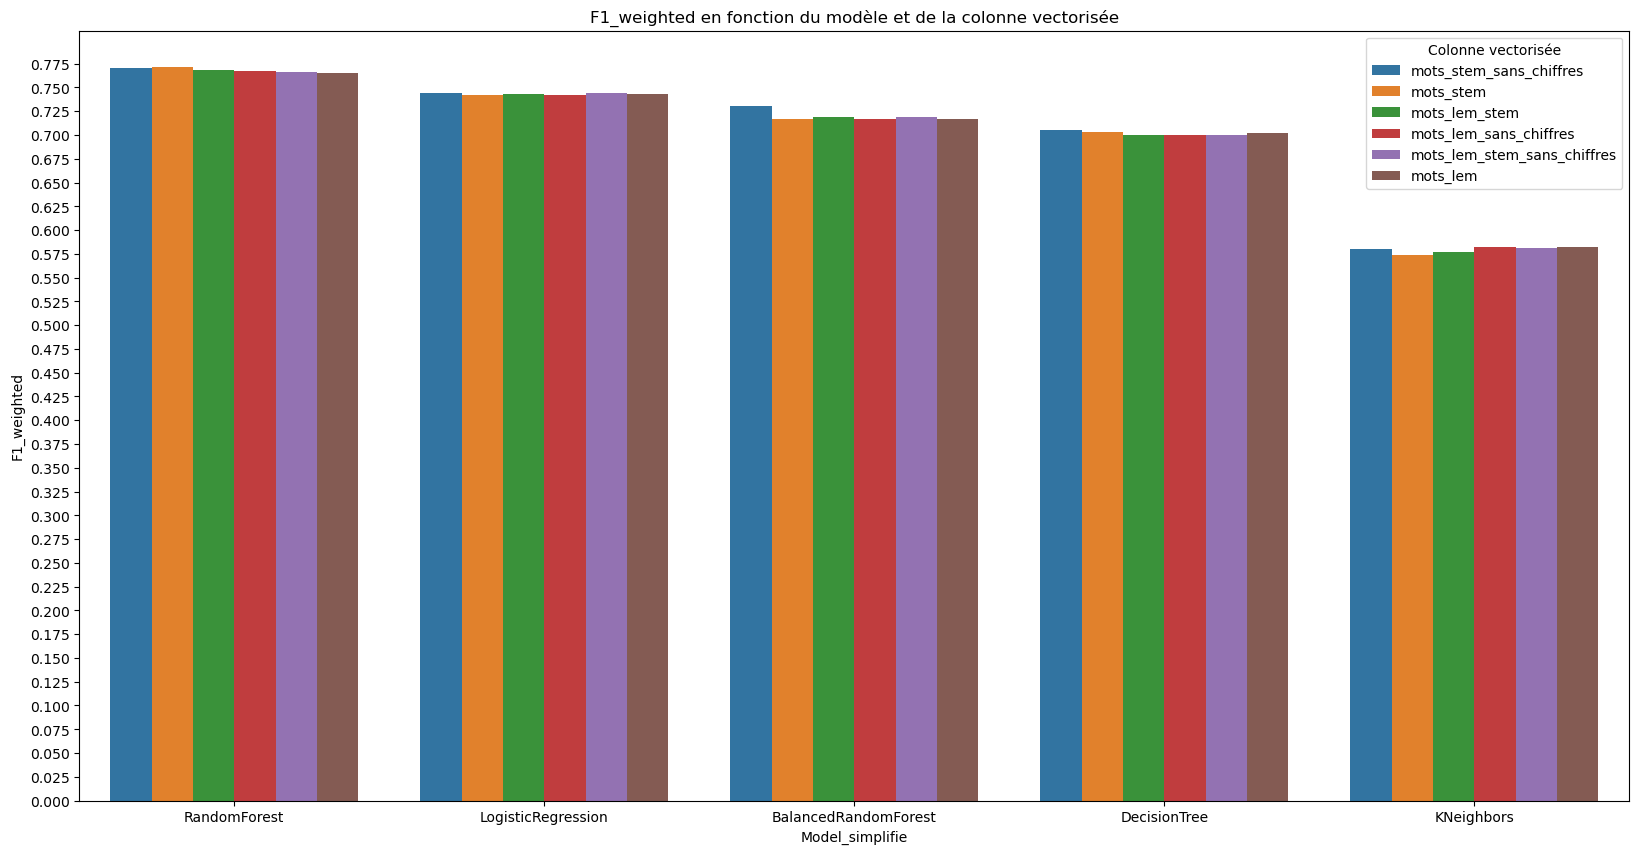

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
sns.barplot(df1, y='F1_weighted', x='Model_simplifie',hue="Colonne vectorisée",errorbar =None);
plt.yticks([i/40 for i in range(0,32,1)])
plt.title("F1_weighted en fonction du modèle et de la colonne vectorisée");
